# Importing the required libraries

In [1]:
# Importing the required libraries
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
from IPython.display import display, HTML
from typing import Optional, Union, Dict, Set, Tuple
from datetime import date, datetime
import upsetplot                            #Intesection analysis
import missingno as msno                    #Visualize missing values
import warnings
import featuretools as ft                   #Feature Engineering
%matplotlib inline     
sns.set(color_codes=True)

# Load the dataset

In [2]:
# Define the URL of the ZIP file
url_zip_file = 'https://lms.ithillel.ua/api/lms/files/658afe8759492765d193f992'

# Download the ZIP file
response = requests.get(url_zip_file)
if response.status_code == 200:
    # Create a BytesIO object from the downloaded content
    zip_file = io.BytesIO(response.content)
else:
    raise Exception(f"Failed to download the file. Status code: {response.status_code}")

# Create a dictionary to store the DataFrames
dataframes = {}

# Open the ZIP file from the BytesIO object
with zipfile.ZipFile(zip_file, 'r') as z:
    # Iterate through each file in the ZIP archive
    for file_name in z.namelist():
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame
            with z.open(file_name) as f:
                df = pd.read_csv(f)
                # Store the DataFrame in the dictionary
                dataframes[file_name] = df

In [3]:
# Looking at CSV Files in a ZIP Archive:
dataframes.keys()

dict_keys(['Players.csv', 'player_data.csv', 'Seasons_Stats.csv'])

In [4]:
# Access the DataFrames using the dictionary keys
player_data = dataframes.get('player_data.csv')
Players = dataframes.get('Players.csv')
Seasons_Stats = dataframes.get('Seasons_Stats.csv')

<h1 style='color:red'> Let's look at the 'player_data' table </h1>

In [5]:
player_data

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University
...,...,...,...,...,...,...,...,...
4545,Ante Zizic,2018,2018,F-C,6-11,250.0,"January 4, 1997",NaN
4546,Jim Zoet,1983,1983,C,7-1,240.0,"December 20, 1953",Kent State University
4547,Bill Zopf,1971,1971,G,6-1,170.0,"June 7, 1948",Duquesne University
4548,Ivica Zubac,2017,2018,C,7-1,265.0,"March 18, 1997",NaN


In [6]:
# Descriptive Statistics
player_data.describe(include='all')

,name,year_start,year_end,position,height,weight,birth_date,college
count,4550,4550.000000,4550.000000,4549,4549,4544.000000,4519,4248
unique,4500,NaN,NaN,7,28,NaN,4161,473
top,George Johnson,NaN,NaN,G,6-7,NaN,"October 25, 1948",University of Kentucky
freq,3,NaN,NaN,1574,473,NaN,3,99
mean,NaN,1985.076264,1989.272527,NaN,NaN,208.908011,NaN,NaN
std,NaN,20.974188,21.874761,NaN,NaN,26.268662,NaN,NaN
min,NaN,1947.000000,1947.000000,NaN,NaN,114.000000,NaN,NaN
25%,NaN,1969.000000,1973.000000,NaN,NaN,190.000000,NaN,NaN
50%,NaN,1986.000000,1992.000000,NaN,NaN,210.000000,NaN,NaN
75%,NaN,2003.000000,2009.000000,NaN,NaN,225.000000,NaN,NaN


<Figure size 1000x600 with 0 Axes>

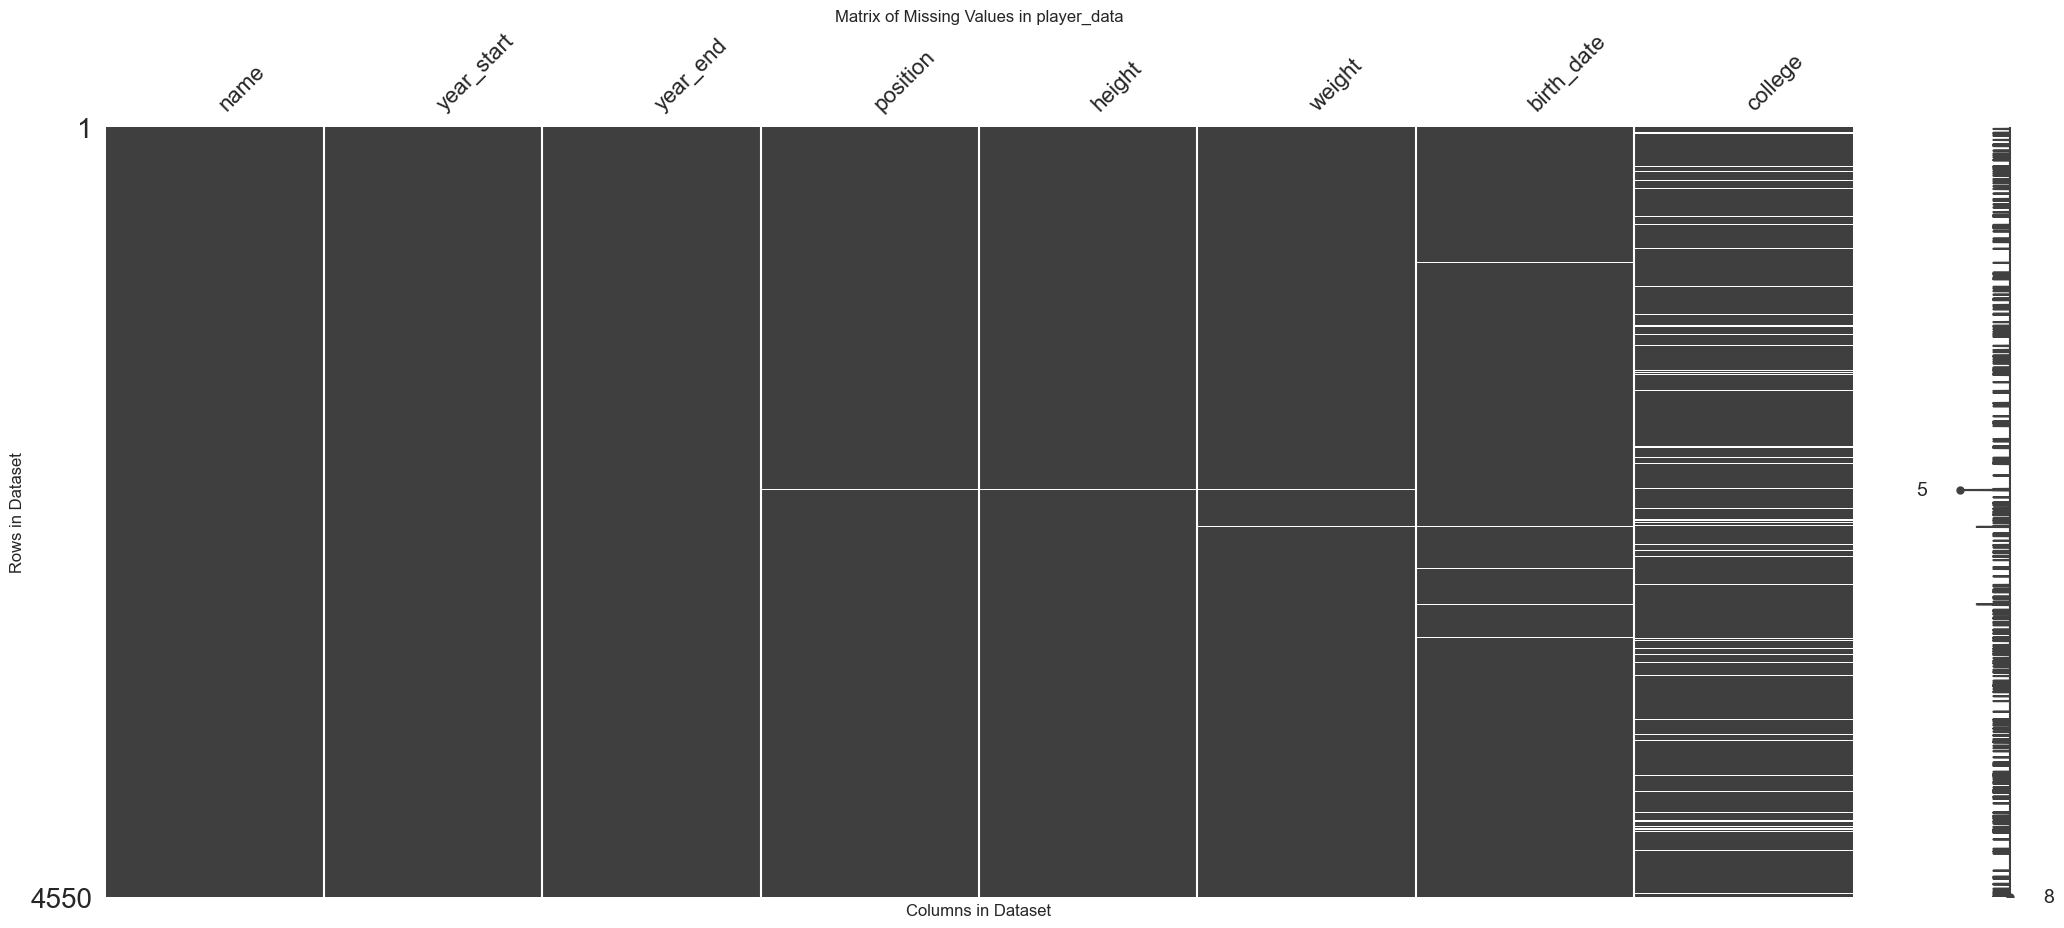

In [7]:
# Visualize missing values
plt.figure(figsize=(10, 6))
msno.matrix(player_data)
plt.title('Matrix of Missing Values in player_data')
plt.xlabel('Columns in Dataset')
plt.ylabel('Rows in Dataset')
plt.show()

><span style="color: red">As can be seen from the graph, the `college` column has the most gaps; `birth_date`, `weight` and `height` the least gaps, it is also clear that there is a row that has 5 gaps out of 8.</span>



<Figure size 1000x600 with 0 Axes>

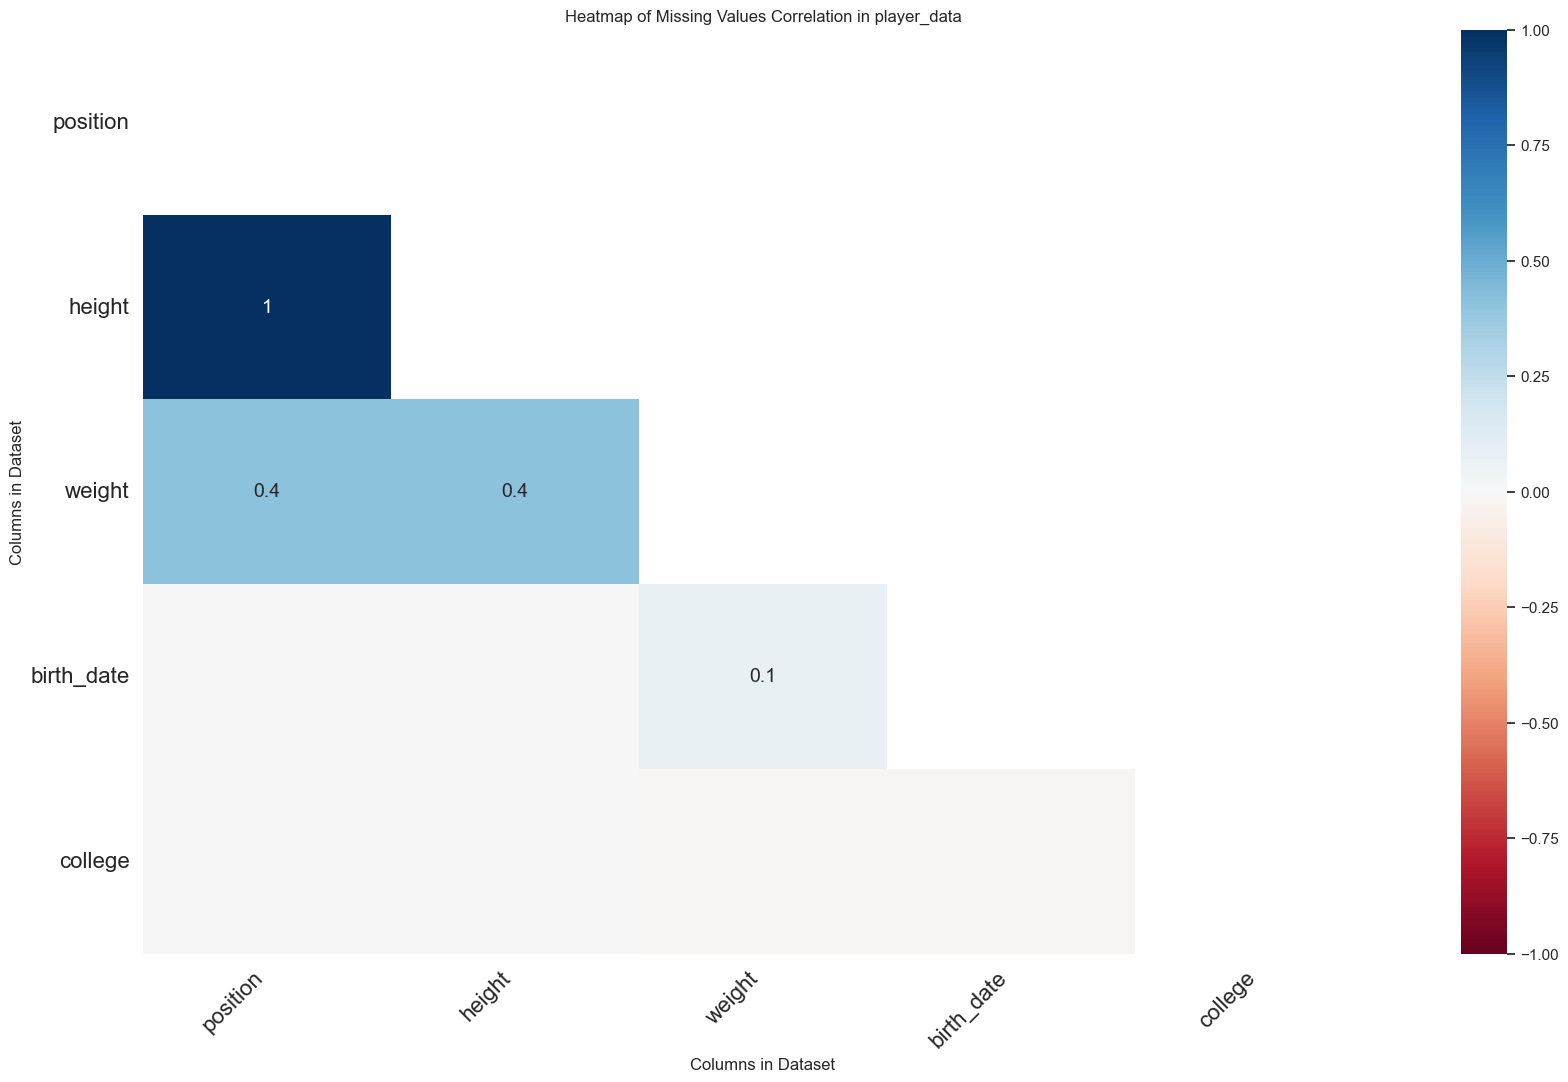

In [8]:
# Visualize the correlation of missing values
plt.figure(figsize=(10, 6))
msno.heatmap(player_data)
plt.title('Heatmap of Missing Values Correlation in player_data')
plt.xlabel('Columns in Dataset')
plt.ylabel('Columns in Dataset')
plt.show()

><span style="color: red">There is a high direct correlation between a player's `position` and his `height`</span>

<h1 style='color:green'> Feature Engineering </h1>

In [9]:
# Function to convert height from feet-inches to meters
def height_to_meters(height: str) -> Optional[float]:
    """
    Converts height from feet-inches format to meters.

    Parameters:
    height (str): Height in feet-inches format, e.g., '6-2'.

    Returns:
    Optional[float]: Height in meters. Returns None if the input format is invalid.
    """
    try:
        feet, inches = map(int, height.split('-'))
        return feet * 0.3048 + inches * 0.0254
    except (ValueError, AttributeError):
        return None  # or you could return a default value like np.nan

def calculate_age_in_days(birth_date: Union[str, pd.Timestamp]) -> Optional[int]:
    """
    Calculates age in days from the birth date to the current date.

    Parameters:
    birth_date (Union[str, pd.Timestamp]): Birth date in the format 'Month Day, Year', 
                                           e.g., 'January 1, 2000', or a pandas Timestamp.

    Returns:
    Optional[int]: Age in days. Returns None if the birth date is invalid or NaN.
    """
    if pd.isna(birth_date):
        return None  # or some other appropriate value, e.g., 0 or np.nan
    date_format = '%B %d, %Y'
    try:
        date_object = datetime.strptime(birth_date, date_format)
        age_in_days = (datetime.now() - date_object).days
        return age_in_days
    except (ValueError, TypeError):
        return None

def calculate_age_start(row: pd.Series) -> Optional[int]:
    """
    Calculates age at the start year (with error handling).

    Parameters:
    row (pd.Series): A row of the DataFrame.

    Returns:
    Optional[int]: The calculated age at start year, or None if there's an error.
    """
    try:
        # Extract last 4 digits from birth date
        birth_year = int(row['birth_date'][-4:])
        age_start = row['year_start'] - birth_year
        return age_start
    except (ValueError, TypeError):
        # Handle potential errors during conversion or subtraction
        # print(f"Error processing row: {row.name}. Skipping calculation.")
        return None

def calculate_age_end(row: pd.Series) -> Optional[int]:
    """
    Calculates age at the end year (with error handling).

    Parameters:
    row (pd.Series): A row of the DataFrame.

    Returns:
    Optional[int]: The calculated age at end year, or None if there's an error.
    """
    try:
        # Extract last 4 digits from birth date
        birth_year = int(row['birth_date'][-4:])
        age_end = row['year_end'] - birth_year
        return age_end
    except (ValueError, TypeError):
        # Handle potential errors during conversion or subtraction
        # print(f"Error processing row: {row.name}. Skipping calculation.")
        return None

In [10]:
# Calculate career duration in years
player_data['Career_Duration'] = player_data['year_end'] - player_data['year_start']

# Convert height from feet-inches format to meters
player_data['height_m'] = player_data['height'].apply(height_to_meters)

# Convert weight from pounds to kilograms
player_data['weight_kg'] = player_data['weight'].apply(lambda w: w / 2.20462)

# Calculate BMI (Body Mass Index) using weight in kg and height in meters
player_data['BMI'] = player_data.apply(lambda row: row['weight_kg'] / row['height_m'] ** 2, axis=1)

# Calculate age in days based on birth date
player_data['age_days'] = player_data['birth_date'].apply(calculate_age_in_days)

# Calculate age at the start year
player_data['age_start'] = player_data.apply(calculate_age_start, axis=1)

# Calculate age at the end year
player_data['age_end'] = player_data.apply(calculate_age_end, axis=1)


# Automatically generating features

In [11]:
# Creating EntitySet
es = ft.EntitySet(id="player_data")

# Adding a data table to EntitySet
es = es.add_dataframe(dataframe_name="player_data", dataframe=player_data,
                      index="index", make_index=True)


feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="player_data",
    trans_primitives=["day", "year", "month", "weekday", "is_weekend"]
)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\

In [12]:
feature_matrix

,year_start,year_end,position,height,weight,college,Career_Duration,height_m,weight_kg,BMI,age_days,age_start,age_end,DAY(birth_date),IS_WEEKEND(birth_date),MONTH(birth_date),WEEKDAY(birth_date),YEAR(birth_date)
index,,,,,,,,,,,,,,,,,,
0,1991,1995,F-C,6-10,240,Duke University,4,2.0828,108.862298,25.094720,20451,23,27,24,False,6,0,1968
1,1969,1978,C-F,6-9,235,Iowa State University,9,2.0574,106.594334,25.182373,28565,23,32,7,True,4,6,1946
2,1970,1989,C,7-2,225,"University of California, Los Angeles",19,2.1844,102.058405,21.388702,28191,23,42,16,False,4,2,1947
3,1991,2001,G,6-1,162,Louisiana State University,10,1.8542,73.482051,21.373130,20193,22,32,9,True,3,6,1969
4,1998,2003,F,6-6,223,San Jose State University,5,1.9812,101.151219,25.770004,18128,24,29,3,True,11,6,1974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,2018,2018,F-C,6-11,250,NaN,0,2.1082,113.398227,25.514241,10030,21,21,4,True,1,5,1997
4546,1983,1983,C,7-1,240,Kent State University,0,2.1590,108.862298,23.354588,25751,30,30,20,True,12,6,1953
4547,1971,1971,G,6-1,170,Duquesne University,0,1.8542,77.110795,22.428593,27773,23,23,7,False,6,0,1948


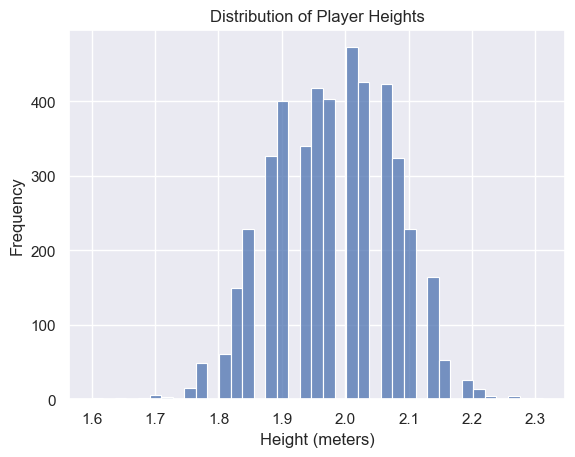

In [13]:
# Plot the histogram for player heights
sns.histplot(player_data['height_m'])  # Histogram for height
plt.xlabel('Height (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Player Heights')
plt.show()

><span style="color: red">The distribution of height among players is subject to the law of normal distribution</span>    
><span style="color: red"></span>

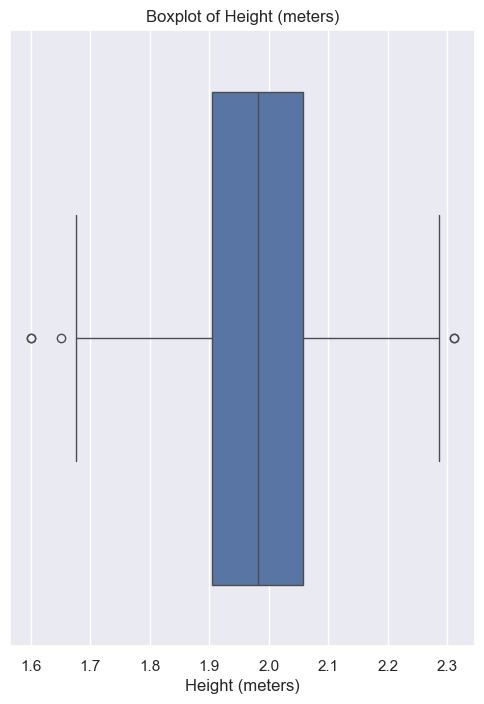

In [14]:
# Create the boxplot
plt.figure(figsize=(6, 8))
sns.boxplot(x=player_data['height_m'])
plt.title('Boxplot of Height (meters)')
plt.xlabel('Height (meters)')
plt.show()

><span style="color: red">Ranging from the first quartile (Q1) to the third quartile (Q3), players' heights range from 190 cm to 205 cm</span>

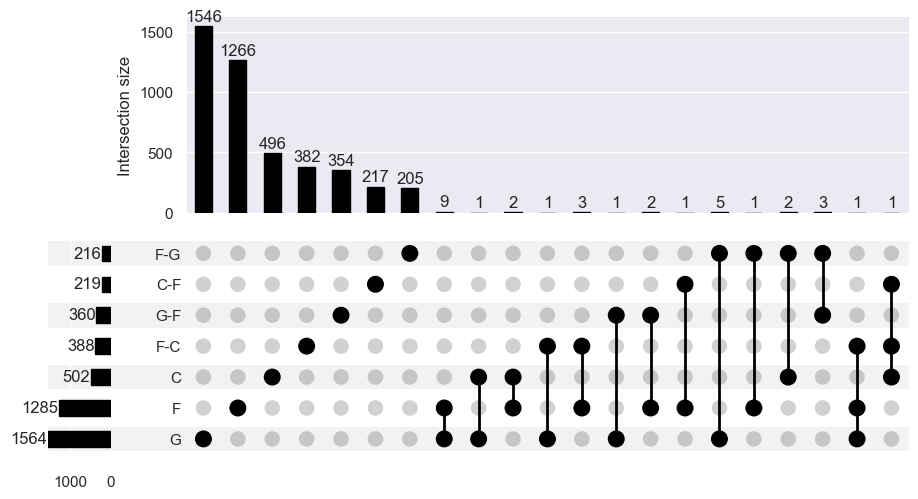

In [15]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a dictionary mapping player positions to unique player names
d: Dict[str, Set[str]] = {}
for pos in player_data['position'].unique():
    players = player_data.loc[player_data['position'] == pos, 'name'].unique()
    players = set(filter(lambda x: pd.notna(x) and x != '', players))  # Filter out NaN and empty strings
    d[pos] = players

def plot_upset(players_set: Dict[str, Set[str]], position_categories: Tuple[str, ...], filename: str) -> None:
    """
    Generates and saves an UpSet plot showing intersections of players across different positions.

    Parameters:
    players_set (Dict[str, Set[str]]): Dictionary where keys are positions and values are sets of player names.
    position_categories (Tuple[str, ...]): Tuple of position categories to include in the plot.
    filename (str): Filename to save the generated plot.

    Returns:
    None
    """
    # Filter out NaN values and convert position_categories to a set for comparison
    position_categories_set = set(position_categories)
    upset_data_sub = upsetplot.from_contents({k: v for k, v in players_set.items() if k in position_categories_set})
    upsetplot.plot(upset_data_sub, show_counts=True)
    plt.savefig(filename)

# Generate and save the UpSet plot
plot_upset(d, ('F-C', 'C', 'G', 'F', 'F-G', 'G-F', 'C-F'), "./upset.png")

><span style="color: red">If we plot the intersections depending on the `name` on the `position` of the players, we can say that most of the namesakes are located in position "G"</span>

In [16]:
# Group by 'position' and calculate the size of each group
player_data.groupby(by='position').size().reset_index(name='counts')

,position,counts
0,C,502
1,C-F,219
2,F,1290
3,F-C,388
4,F-G,216
5,G,1574
6,G-F,360


In [17]:
# Group by 'position' and calculate the sum of NaN values for each group
player_data.groupby('position').apply(lambda x: x.isna().sum(),include_groups=False)

,index,name,year_start,year_end,height,weight,birth_date,college,Career_Duration,height_m,weight_kg,BMI,age_days,age_start,age_end
position,,,,,,,,,,,,,,,
C,0,0,0,0,0,2,3,91,0,0,2,2,3,3,3
C-F,0,0,0,0,0,0,1,15,0,0,0,0,1,1,1
F,0,0,0,0,0,1,16,73,0,0,1,1,16,16,16
F-C,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0
F-G,0,0,0,0,0,0,3,8,0,0,0,0,3,3,3
G,0,0,0,0,0,2,7,64,0,0,2,2,7,7,7
G-F,0,0,0,0,0,0,1,23,0,0,0,0,1,1,1


<h1 style='color:red'> Let's look at the 'Players' table </h1>

In [18]:
Players

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky
...,...,...,...,...,...,...,...,...
3917,3917,Troy Williams,198.0,97.0,South Carolina State University,1969.0,Columbia,South Carolina
3918,3918,Kyle Wiltjer,208.0,108.0,Gonzaga University,1992.0,Portland,Oregon
3919,3919,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",1996.0,Hendersonville,Tennessee
3920,3920,Paul Zipser,203.0,97.0,NaN,1994.0,Heidelberg,Germany


In [19]:
# Generate descriptive statistics for all columns including categorical variables
Players.describe(include='all')

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
count,3922.000000,3921,3921.000000,3921.000000,3573,3921.00000,3452,3439
unique,NaN,3921,NaN,NaN,422,NaN,1264,128
top,NaN,Curly Armstrong,NaN,NaN,University of Kentucky,NaN,Chicago,California
freq,NaN,1,NaN,NaN,89,NaN,114,344
mean,1960.500000,NaN,198.704922,94.783219,NaN,1962.37975,NaN,NaN
std,1132.328206,NaN,9.269761,12.039515,NaN,20.33491,NaN,NaN
min,0.000000,NaN,160.000000,60.000000,NaN,1913.00000,NaN,NaN
25%,980.250000,NaN,190.000000,86.000000,NaN,1948.00000,NaN,NaN
50%,1960.500000,NaN,198.000000,95.000000,NaN,1964.00000,NaN,NaN
75%,2940.750000,NaN,206.000000,102.000000,NaN,1979.00000,NaN,NaN


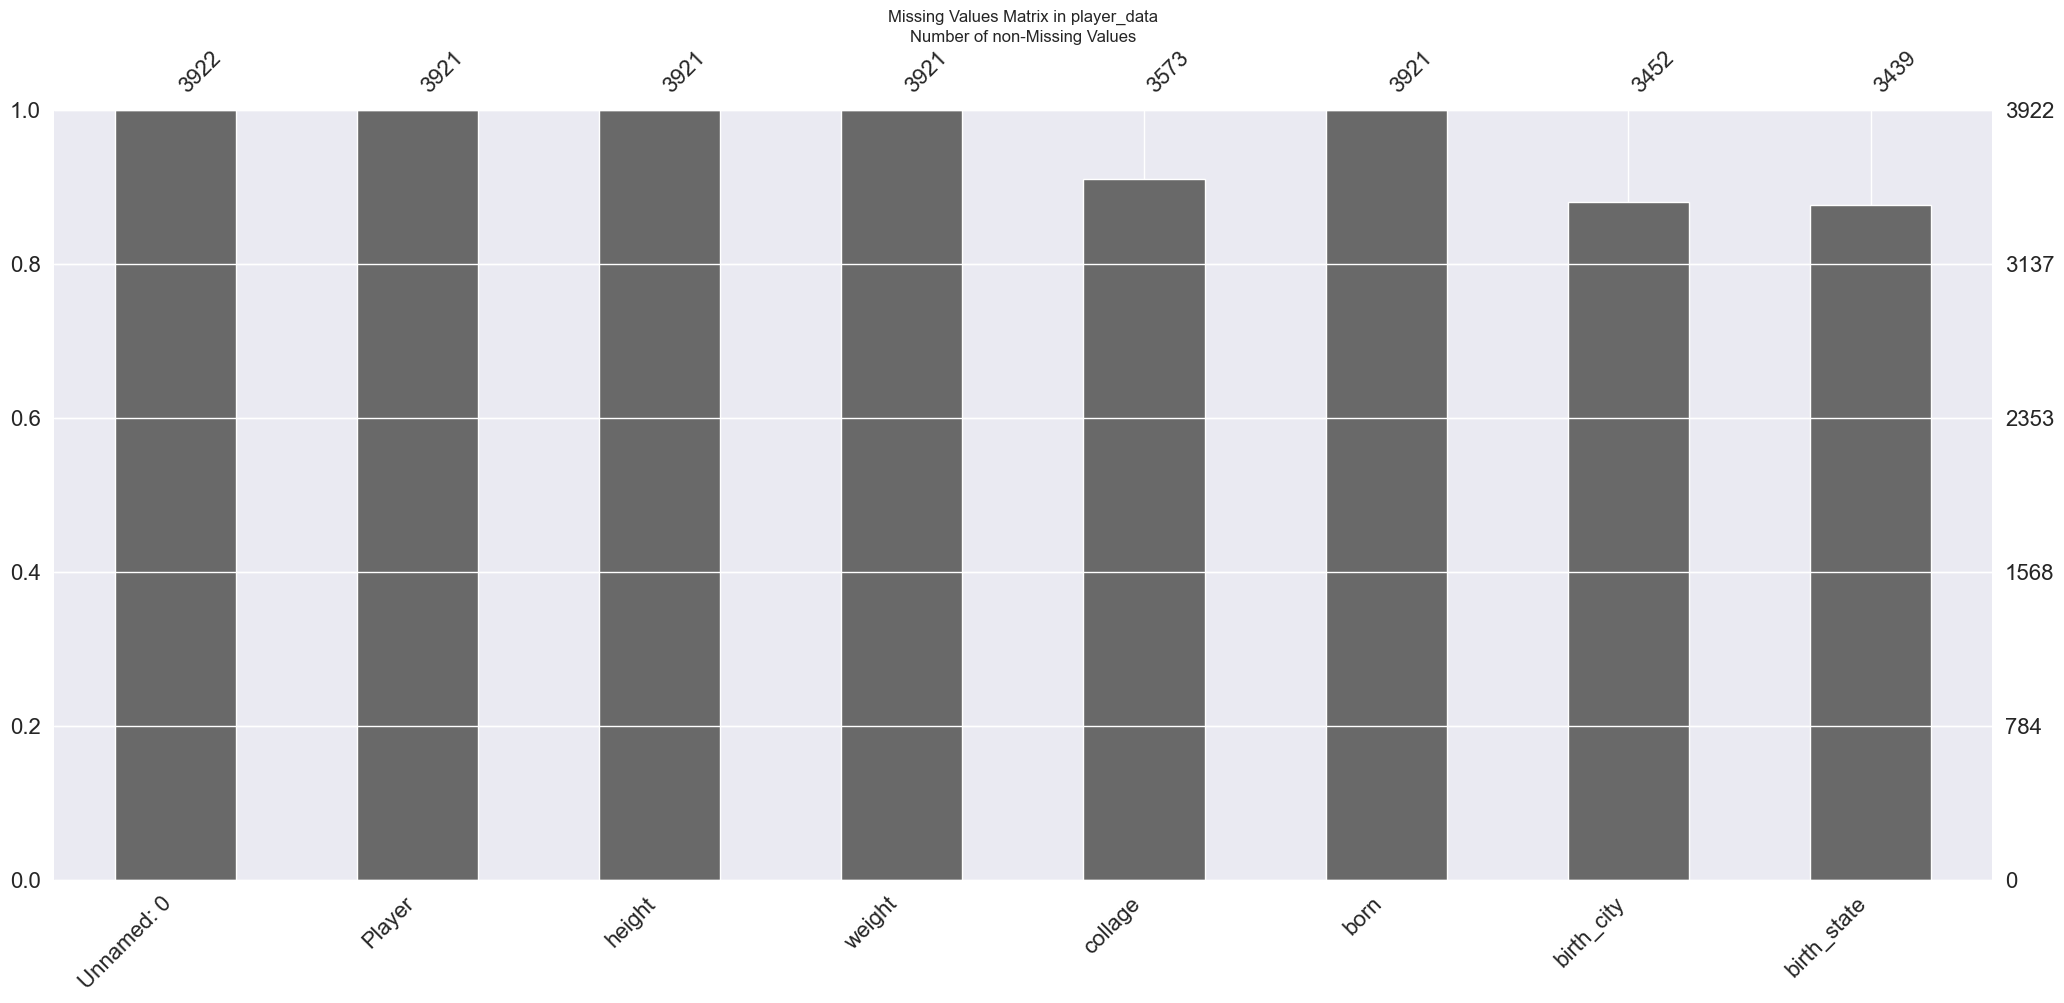

In [20]:
# Visualize missing values
plt.figure(figsize=(10, 6))
msno.bar(Players)
plt.title('Missing Values Matrix in player_data')
plt.xlabel('Number of non-Missing Values')
plt.show()

><span style="color: red">The table `Players` with the most passes is also in the `college` `birth_city` and `birth_state` column</span>

<h1 style='color:red'> Let's look at the 'Seasons_Stats' table </h1>

In [21]:
Seasons_Stats

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


In [22]:
# Generate descriptive statistics for all columns including categorical variables
Seasons_Stats.describe(include='all')

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,24691.000000,24624.000000,24624,24624,24616.000000,24624,24624.000000,18233.000000,24138.000000,24101.000000,...,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000
unique,NaN,NaN,3921,23,NaN,69,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Eddie Johnson,PF,NaN,TOT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,33,4966,NaN,2123,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12345.000000,1992.594989,NaN,NaN,26.664405,NaN,50.837110,23.593375,1209.720317,12.479071,...,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350
std,7127.822084,17.429594,NaN,NaN,3.841892,NaN,26.496161,28.632387,941.146575,6.039014,...,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981
min,0.000000,1950.000000,NaN,NaN,18.000000,NaN,1.000000,0.000000,0.000000,-90.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6172.500000,1981.000000,NaN,NaN,24.000000,NaN,27.000000,0.000000,340.000000,9.800000,...,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000
50%,12345.000000,1996.000000,NaN,NaN,26.000000,NaN,58.000000,8.000000,1053.000000,12.700000,...,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364.000000
75%,18517.500000,2007.000000,NaN,NaN,29.000000,NaN,75.000000,45.000000,1971.000000,15.600000,...,0.808000,91.000000,212.000000,322.000000,160.000000,60.000000,29.000000,112.000000,182.000000,778.000000


<Figure size 1000x600 with 0 Axes>

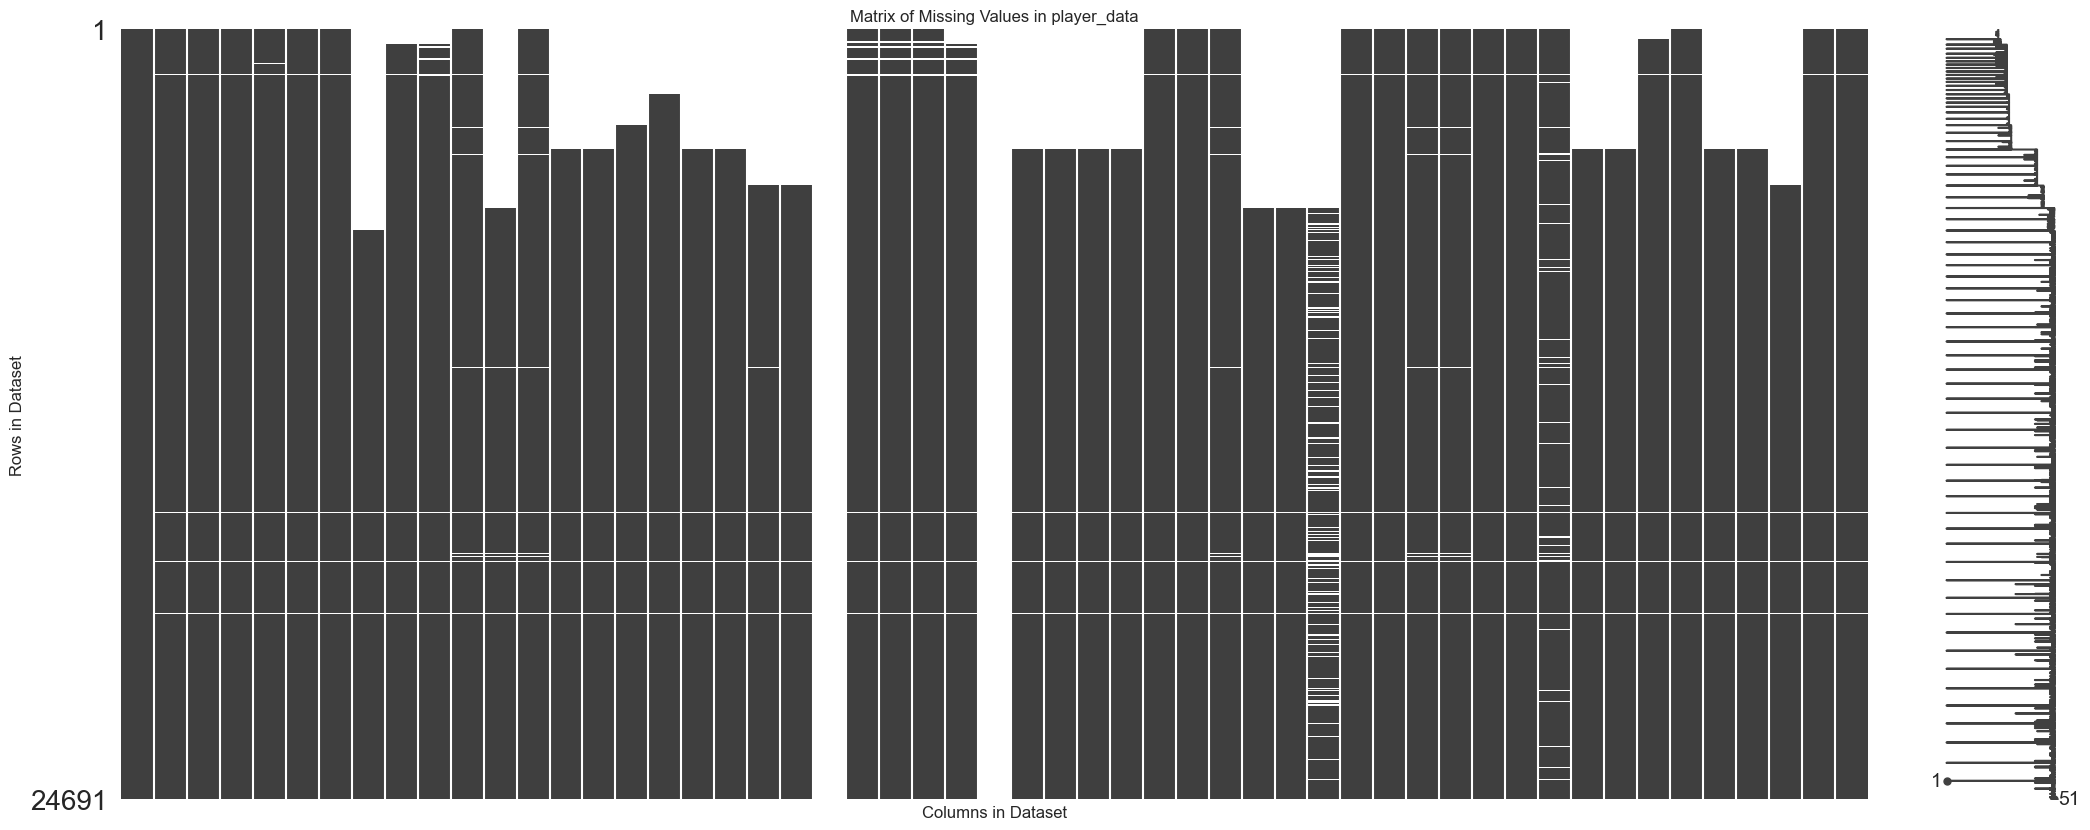

In [23]:
# Visualize missing values
plt.figure(figsize=(10, 6))
msno.matrix(Seasons_Stats)
plt.title('Matrix of Missing Values in player_data')
plt.xlabel('Columns in Dataset')
plt.ylabel('Rows in Dataset')
plt.show()

><span style="color: red">in the `Seasons_Stats` table there are two fields for which all data is missing</span>

<h1 style='color:green'> Feature Engineering </h1>

In [24]:
# Total Rebounds (TRB)
Seasons_Stats['Total_Rebounds'] = Seasons_Stats['ORB'] + Seasons_Stats['DRB']

# Player Efficiency Rating (PER) per Game
Seasons_Stats['PER_per_Game'] = Seasons_Stats['PER'] / Seasons_Stats['G']

# Scoring Efficiency
Seasons_Stats['Scoring_Efficiency'] = Seasons_Stats['PTS'] / Seasons_Stats['G']

In [25]:
Seasons_Stats

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,Total_Rebounds,PER_per_Game,Scoring_Efficiency
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,NaN,176.0,NaN,NaN,NaN,217.0,458.0,NaN,NaN,7.269841
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,NaN,109.0,NaN,NaN,NaN,99.0,279.0,NaN,NaN,5.693878
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,NaN,140.0,NaN,NaN,NaN,192.0,438.0,NaN,NaN,6.537313
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,NaN,20.0,NaN,NaN,NaN,29.0,63.0,NaN,NaN,4.200000
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,NaN,20.0,NaN,NaN,NaN,27.0,59.0,NaN,NaN,4.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,405.0,99.0,62.0,58.0,65.0,189.0,639.0,405.0,0.269355,10.306452
24687,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,124.0,42.0,7.0,21.0,20.0,61.0,178.0,124.0,0.254902,3.490196
24688,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,35.0,4.0,2.0,5.0,3.0,17.0,23.0,35.0,0.384211,1.210526
24689,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,125.0,36.0,15.0,16.0,40.0,78.0,240.0,125.0,0.156818,5.454545


<h1 style='color:orange'> Some visualizations </h1>

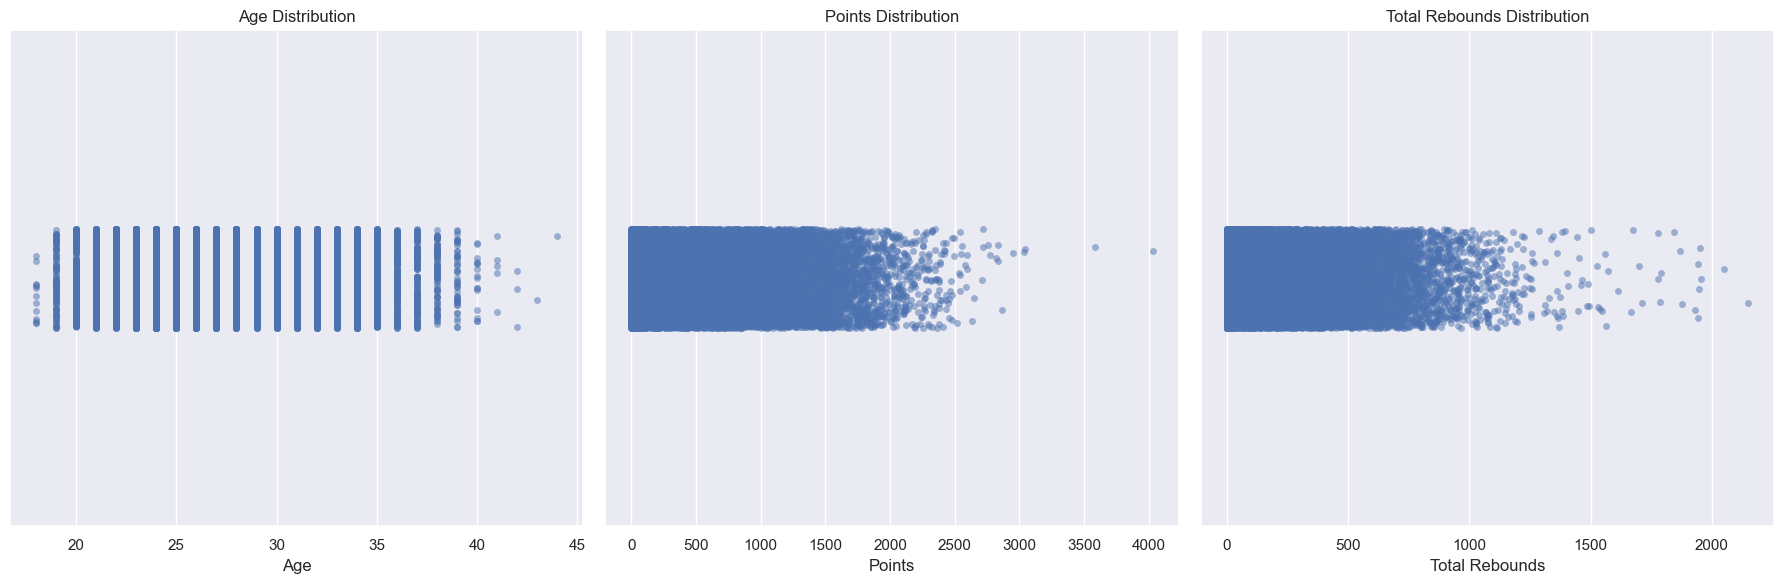

In [26]:
# Removing rows with missing values in selected columns
df_filtered = Seasons_Stats.dropna(subset=['Age', 'PTS', 'TRB'])

# Creating three dot plots
plt.figure(figsize=(18, 6))

# Dot plot for players' age
plt.subplot(1, 3, 1)
sns.stripplot(x='Age', data=df_filtered, jitter=True, alpha=0.5)
plt.title('Age Distribution')
plt.xlabel('Age')

# Dot plot for points (PTS)
plt.subplot(1, 3, 2)
sns.stripplot(x='PTS', data=df_filtered, jitter=True, alpha=0.5)
plt.title('Points Distribution')
plt.xlabel('Points')

# Dot plot for total rebounds (TRB)
plt.subplot(1, 3, 3)
sns.stripplot(x='TRB', data=df_filtered, jitter=True, alpha=0.5)
plt.title('Total Rebounds Distribution')
plt.xlabel('Total Rebounds')

plt.tight_layout()
plt.show()

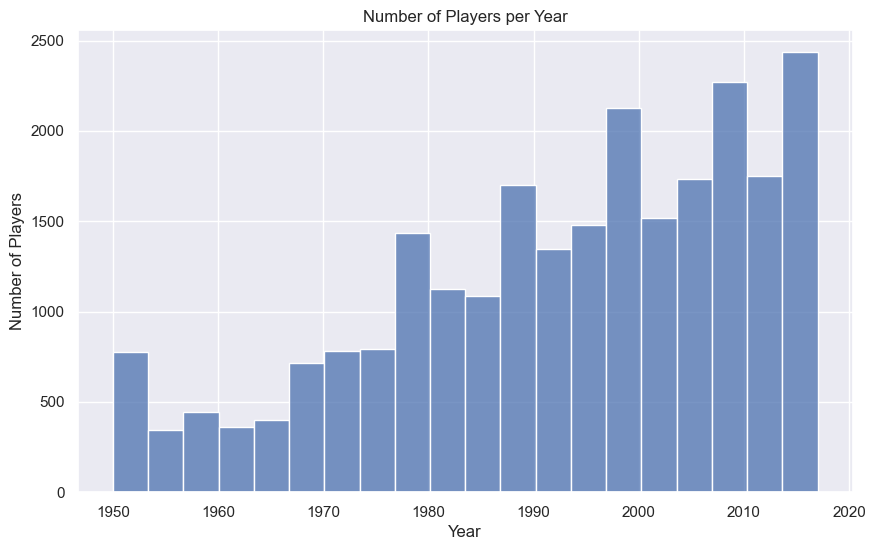

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=Seasons_Stats, x='Year', bins=20, kde=False)
plt.title('Number of Players per Year')
plt.xlabel('Year')
plt.ylabel('Number of Players')
plt.show()


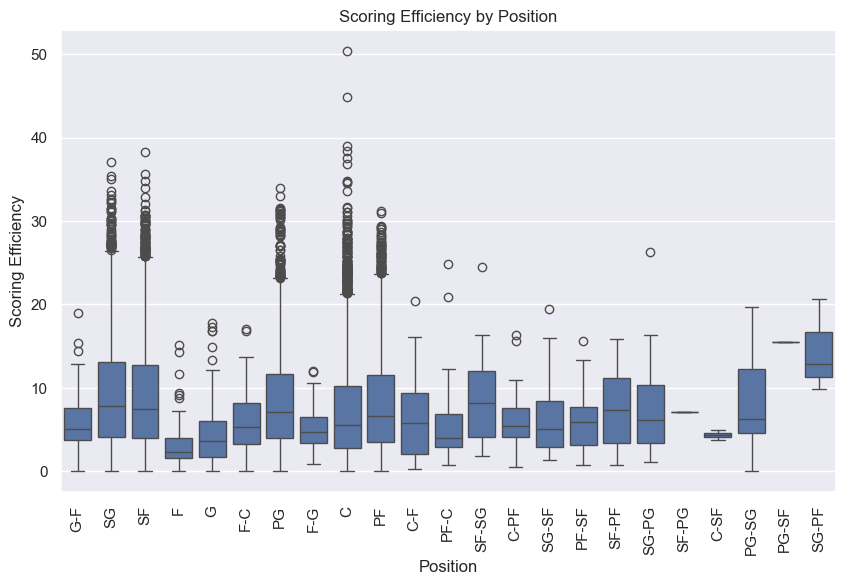

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pos', y='Scoring_Efficiency', data=Seasons_Stats)
plt.title('Scoring Efficiency by Position')
plt.xlabel('Position')
plt.ylabel('Scoring Efficiency')
plt.xticks(rotation=90)
plt.show()

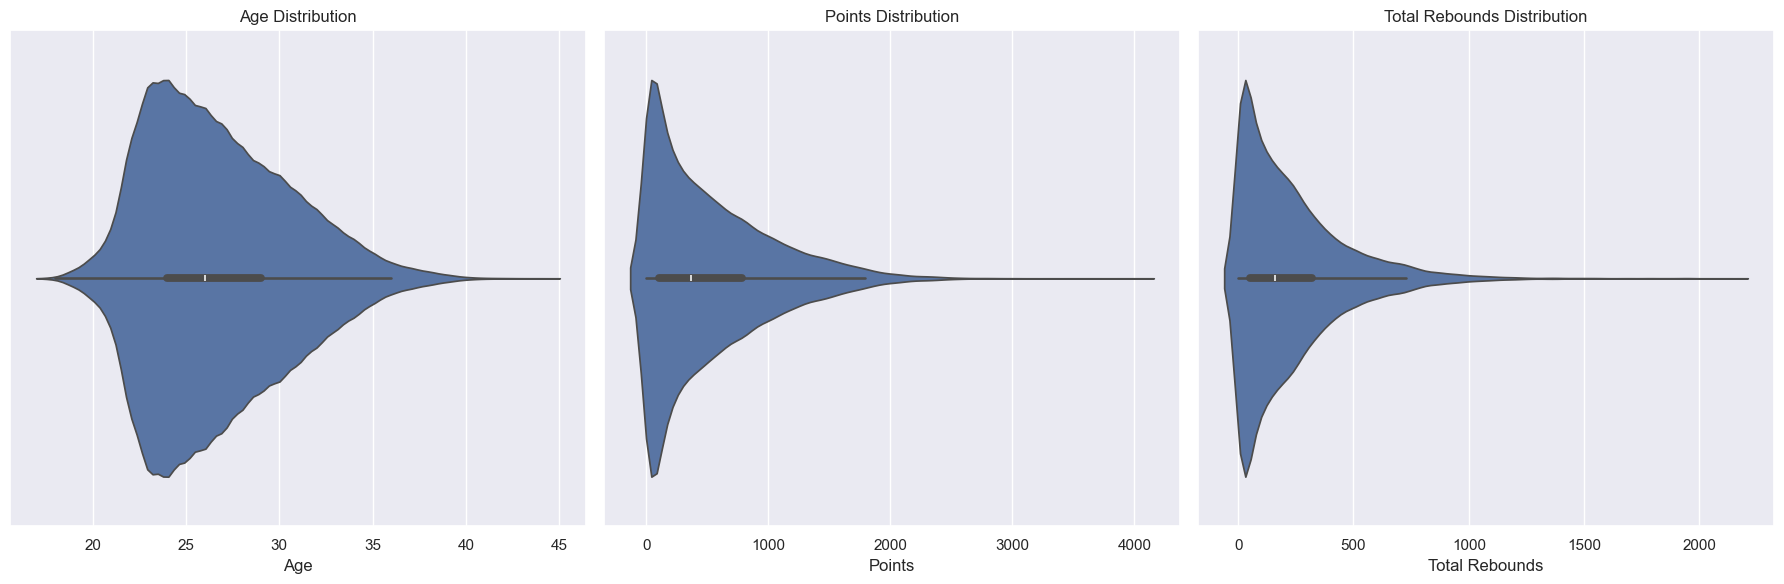

In [29]:
# Removing rows with missing values in selected columns
df_filtered = Seasons_Stats.dropna(subset=['Age', 'PTS', 'TRB'])

# Creating three violin plots
plt.figure(figsize=(18, 6))

# Violin plot for players' age
plt.subplot(1, 3, 1)
sns.violinplot(x='Age', data=df_filtered)
plt.title('Age Distribution')
plt.xlabel('Age')

# Violin plot for points (PTS)
plt.subplot(1, 3, 2)
sns.violinplot(x='PTS', data=df_filtered)
plt.title('Points Distribution')
plt.xlabel('Points')

# Violin plot for rebounds (TRB)
plt.subplot(1, 3, 3)
sns.violinplot(x='TRB', data=df_filtered)
plt.title('Total Rebounds Distribution')
plt.xlabel('Total Rebounds')

plt.tight_layout()
plt.show()


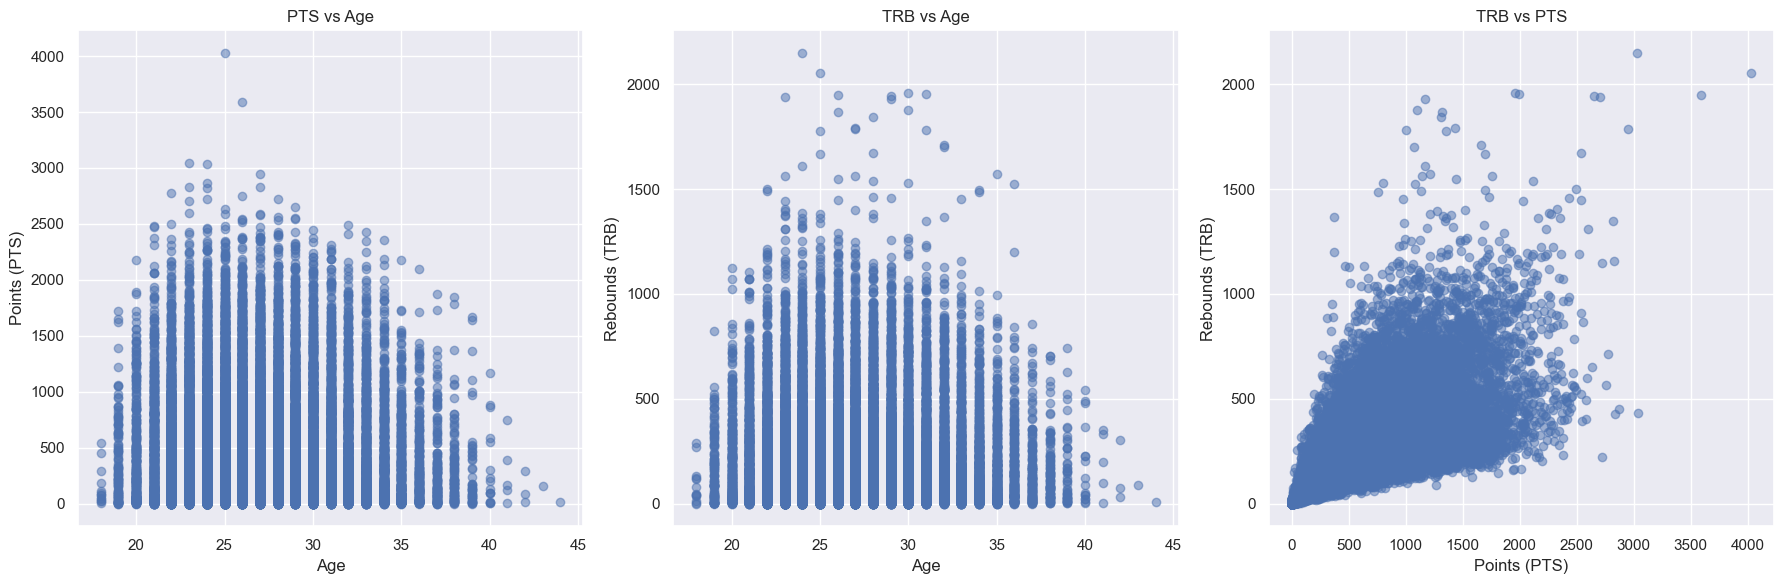

In [30]:
plt.figure(figsize=(18, 6))

# Scatter plot for players' age vs points (PTS)
plt.subplot(1, 3, 1)
plt.scatter(df_filtered['Age'], df_filtered['PTS'], alpha=0.5)
plt.title('PTS vs Age')
plt.xlabel('Age')
plt.ylabel('Points (PTS)')

# Scatter plot for players' age vs rebounds (TRB)
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['Age'], df_filtered['TRB'], alpha=0.5)
plt.title('TRB vs Age')
plt.xlabel('Age')
plt.ylabel('Rebounds (TRB)')

# Scatter plot for points (PTS) vs rebounds (TRB)
plt.subplot(1, 3, 3)
plt.scatter(df_filtered['PTS'], df_filtered['TRB'], alpha=0.5)
plt.title('TRB vs PTS')
plt.xlabel('Points (PTS)')
plt.ylabel('Rebounds (TRB)')

plt.tight_layout()
plt.show()